---
title: iCOM SSNR  
authors: [Julie Marie Bekkevold, Georgios Varnavides]  
date: 2025-03-31  
---

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import ctf # import custom plotting / utils
import cmasher as cmr 
import tqdm

## 4D-STEM Simulation

In [78]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

cmap = cmr.eclipse
icom_line_color = 'cornflowerblue'

In [79]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

In [80]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

In [81]:
probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

def simulate_intensities(defocus):
    probe_array_fourier = probe_array_fourier_0 * np.exp(-1j * np.pi * wavelength * q**2 * defocus)
    
    # normalized s.t. np.sum(np.abs(probe_array_fourier)**2) = 1.0
    probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))
    
    # we then take the inverse FFT, and normalize s.t. np.sum(np.abs(probe_array)**2) = 1.0
    probe_array = np.fft.ifft2(probe_array_fourier) * n
    
    
    intensities = ctf.simulate_data(
        complex_obj,
        probe_array,
        row,
        col,
    ).reshape((sx,sy,n,n))**2 / n**2
    
    return intensities, probe_array_fourier

ints, probe = simulate_intensities(defocus=0)

In [82]:
# Spatial frequencies
kx = ky = np.fft.fftfreq(n,sampling).astype(np.float32)
kxa, kya = np.meshgrid(kx, ky, indexing='ij')

k2 = kxa**2 + kya**2
k = np.sqrt(k2)
k2[0, 0] = np.inf

# iCoM operators
kx_op = -1.0j * kxa / k2
ky_op = -1.0j * kya / k2

def compute_icom(
    intensities,
):
    """ """
    ints_sums = intensities.sum((-1,-2))
    com_x = np.sum(intensities * kxa,axis=(-1,-2)) / ints_sums
    com_y = np.sum(intensities * kya,axis=(-1,-2)) / ints_sums

    icom = np.real(np.fft.ifft2(np.fft.fft2(com_x)*kx_op + np.fft.fft2(com_y)*ky_op))

    return icom

def compute_finite_icom(
    intensities,
    num_electrons_per_probe,
):
    """ """
    finite_ints = np.random.poisson(
        intensities * num_electrons_per_probe,
    )
    finite_ints_sums = finite_ints.sum((-1,-2))
    finite_com_x = np.sum(finite_ints * kxa,axis=(-1,-2)) / finite_ints_sums
    finite_com_y = np.sum(finite_ints * kya,axis=(-1,-2)) / finite_ints_sums

    finite_icom = np.real(np.fft.ifft2(np.fft.fft2(finite_com_x)*kx_op + np.fft.fft2(finite_com_y)*ky_op))

    return finite_icom

In [83]:
def annular_segmented_detectors(
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling

    k_x = np.fft.fftfreq(nx,sx)
    k_y = np.fft.fftfreq(ny,sy)

    k = np.sqrt(k_x[:,None]**2 + k_y[None,:]**2)
    radial_mask = ((inner_radius <= k) & (k < outer_radius))
    
    theta = (np.arctan2(k_y[None,:], k_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    
    return angular_bins

def compute_com_using_virtual_detectors(
    corner_centered_intensities,
    center_centered_masks,
    kxa,kya,
):
    """ """
    corner_centered_intensities_sum = corner_centered_intensities.sum((-1,-2))
    masks = np.fft.ifftshift(np.asarray(center_centered_masks),axes=(-1,-2))

    sx,sy = corner_centered_intensities.shape[:2]
    com_x = np.zeros((sx,sy))
    com_y = np.zeros((sx,sy))
    
    for mask in masks:
        kxa_i,kya_i=np.where(mask)
        patches= corner_centered_intensities[:,:,kxa_i,kya_i].sum(-1) / corner_centered_intensities_sum
        com_x += patches * np.mean(kxa[kxa_i,kya_i])
        com_y += patches * np.mean(kya[kxa_i,kya_i])
        
    return com_x, com_y

def compute_icom_segmented(
    intensities,
    center_centered_masks,
):
    """ """
    com_x, com_y = compute_com_using_virtual_detectors(
        intensities,
        center_centered_masks,
        kxa,kya,
    )

    icom = np.real(np.fft.ifft2(np.fft.fft2(com_x)*kx_op + np.fft.fft2(com_y)*ky_op))

    return icom

def compute_finite_icom_segmented(
    intensities,
    num_electrons_per_probe,
    center_centered_masks,
):
    """ """
    finite_ints = np.random.poisson(
        intensities * num_electrons_per_probe,
    )
    finite_com_x, finite_com_y = compute_com_using_virtual_detectors(
        finite_ints,
        center_centered_masks,
        kxa,kya,
    )

    finite_icom = np.real(np.fft.ifft2(np.fft.fft2(finite_com_x)*kx_op + np.fft.fft2(finite_com_y)*ky_op))

    return finite_icom

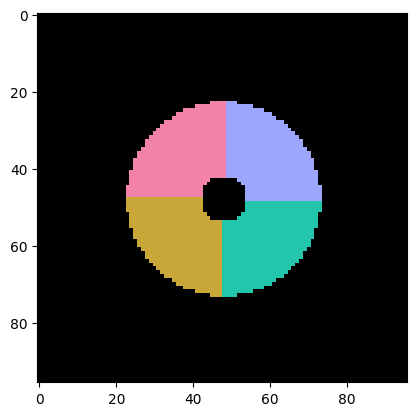

In [84]:
virtual_masks_annular_4 = annular_segmented_detectors(
    gpts=(n,n),
    sampling=(sampling,sampling),
    n_angular_bins=4,
    inner_radius=0.25,
    outer_radius=q_probe*1.05,
    rotation_offset=0,
)   

plt.imshow(
    ctf.visualize.combined_images_rgb(
        virtual_masks_annular_4
    )
)

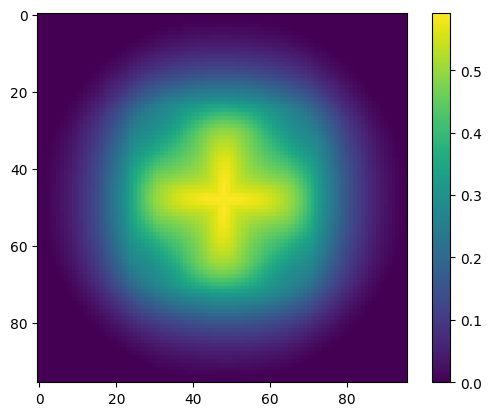

In [88]:
icom_segmented = compute_icom_segmented(
    ints,
    virtual_masks_annular_4
)
ctf_annular_4 = ctf.compute_ctf(icom_segmented)

plt.imshow(
    np.fft.fftshift(ctf_annular_4)
)
plt.colorbar()

In [90]:
ctf_x_2 = (
    np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * weighted_detector_x
            ).conj() * np.fft.fft2(
                normalized_aperture
            )
        )
    )
)

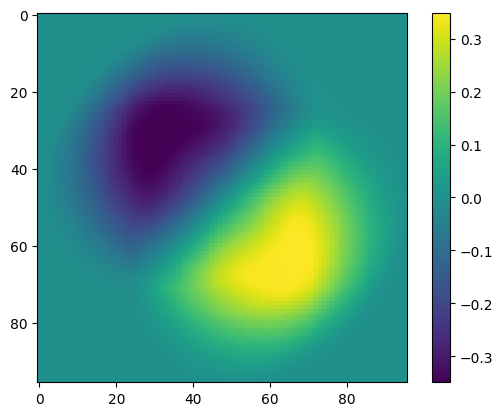

In [94]:
plt.imshow(
    np.fft.fftshift(
        ctf_x
    )
)
plt.colorbar()

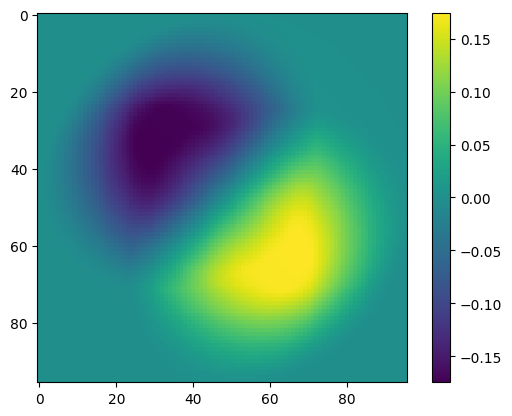

In [95]:
plt.imshow(
    np.fft.fftshift(
        ctf_x_2
    )
)
plt.colorbar()

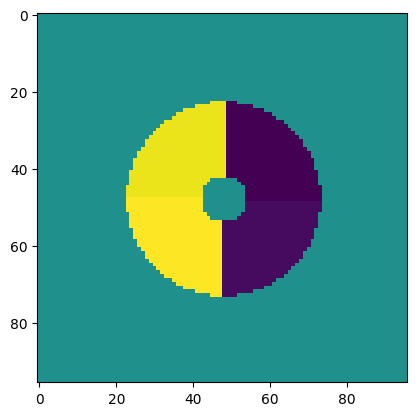

In [102]:
plt.imshow(
    np.fft.fftshift(weighted_detector_y)
)

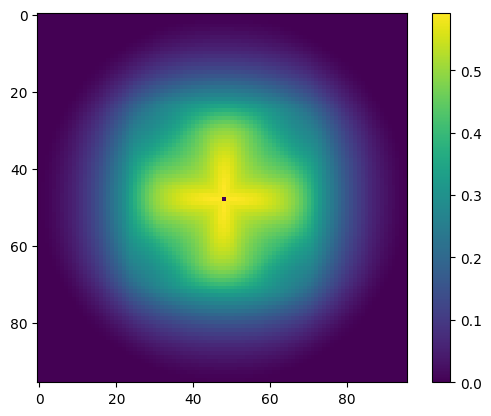

In [100]:
detector_com_x = [
    kxa[np.where(np.fft.ifftshift(mask))].mean() for mask in virtual_masks_annular_4
]

detector_com_y = [
    kya[np.where(np.fft.ifftshift(mask))].mean() for mask in virtual_masks_annular_4
]

weighted_detector_x = np.tensordot(
    np.fft.ifftshift(virtual_masks_annular_4),
    np.array(detector_com_x),
    axes=(0,0)
)

weighted_detector_y = np.tensordot(
    np.fft.ifftshift(virtual_masks_annular_4),
    np.array(detector_com_y),
    axes=(0,0)
)

ctf_x = (
    np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * weighted_detector_x
            ).conj() * np.fft.fft2(
                normalized_aperture
            )
        )
    )- np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * weighted_detector_x
            ) * np.fft.fft2(
                normalized_aperture
            ).conj()
        )
    )
)

ctf_y = (
    np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * weighted_detector_y
            ).conj() * np.fft.fft2(
                normalized_aperture
            )
        )
    )- np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * weighted_detector_y
            ) * np.fft.fft2(
                normalized_aperture
            ).conj()
        )
    )
)

ctf_i = np.abs(
    ctf_x * kx_op + ctf_y * ky_op
)

plt.imshow(
    np.fft.fftshift(ctf_i)
)
plt.colorbar()

In [86]:
# q_bins, I_bins = radially_average_ctf(ctf_annular_4,(sampling,sampling))
# plt.plot(q_bins[1:],I_bins[1:])

In [16]:
def compute_weighted_ctf(
    center_centered_detector_mask,
    progress_bar = False
):
    """ """
    ctf = np.empty((n,n))
    detector_mask = np.fft.ifftshift(center_centered_detector_mask)
    asymmetric_detector = (detector_mask - np.roll(detector_mask[::-1,::-1],(1,1),(0,1)))/2
    aperture = probe_array_fourier_0 / np.sqrt(probe_array_fourier_0.sum())
    
    for i in tqdm.trange(n, disable = not progress_bar):
        for j in range(n):
            shifted_aperture = np.roll(aperture,(i,j),(0,1))
            ctf[i,j] = np.sum(aperture * shifted_aperture * asymmetric_detector)

    return ctf

In [17]:
def return_aperture_overlap(
    ind_x,
    ind_y,
    corner_centered_masks,
):
    """ """
    inverse_mask = (1-corner_centered_masks.sum(0)).astype(np.bool_)

    aperture = probe_array_fourier_0 / np.sqrt(probe_array_fourier_0.sum())
    shifted_probe_plus = np.roll(aperture,(-ind_x,-ind_y),axis=(0,1))
    shifted_probe_minus = np.roll(aperture,(ind_x,ind_y),axis=(0,1))

    gamma = aperture * shifted_probe_minus - aperture * shifted_probe_plus

    for mask in corner_centered_masks:
        val = np.sum(gamma * mask) / np.sum(mask)
        gamma[mask] = val
    gamma[inverse_mask] = 0.0 
    
    return gamma

def mask_gamma_using_virtual_detectors(
    corner_centered_gamma,
    center_centered_masks,
): 
    """ """
    
    masks = np.fft.ifftshift(np.asarray(center_centered_masks).astype(np.bool_),axes=(-1,-2))
    inverse_mask = (1-masks.sum(0)).astype(np.bool_)

    for mask in masks:
        val = np.sum(corner_centered_gamma * mask) / np.sum(mask)
        corner_centered_gamma[mask] = val
    corner_centered_gamma[inverse_mask] = 0.0 

    return None

def return_ssb_ctf(
    center_centered_masks,
    progress_bar = False
):
    """ """
    gamma_array = np.zeros((n,n))
    masks = np.fft.ifftshift(np.asarray(center_centered_masks).astype(np.bool_),axes=(-1,-2))
    
    for ind_x in range(n):
        for ind_y in range(n):
            omega = q[ind_x,ind_y]
            if omega < 2*q_probe:
                gamma_array[ind_x,ind_y] = np.abs(
                    return_aperture_overlap(
                        ind_x,
                        ind_y,
                        masks
                    )
                ).sum() / 2
                
    return gamma_array

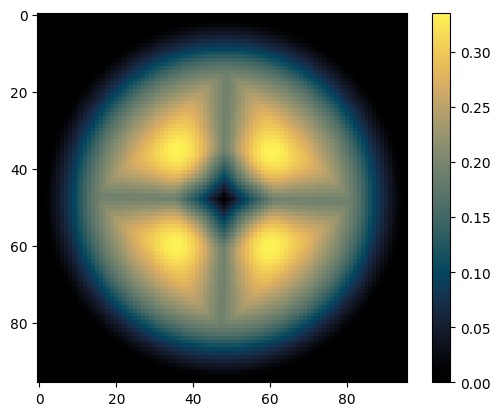

In [18]:
ssb_ctf_gamma = return_ssb_ctf(
        virtual_masks_annular_4
    )

plt.imshow(
    np.fft.fftshift(
        ssb_ctf_gamma
    ),
    cmap=cmr.eclipse
)
plt.colorbar()

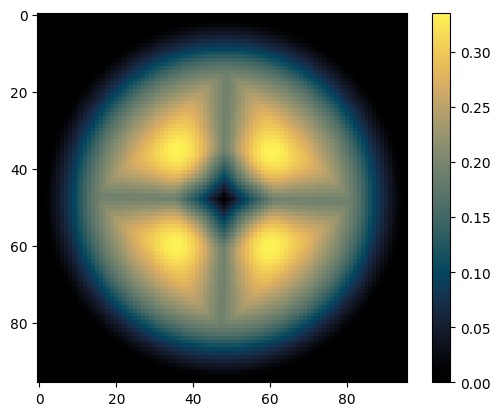

In [19]:
asymmetric_detector_ctf =sum(
    [
        np.abs(compute_weighted_ctf(mask)) for mask in virtual_masks_annular_4
    ]
)

plt.imshow(
    np.fft.fftshift(asymmetric_detector_ctf),
    cmap=cmr.eclipse
)
plt.colorbar()

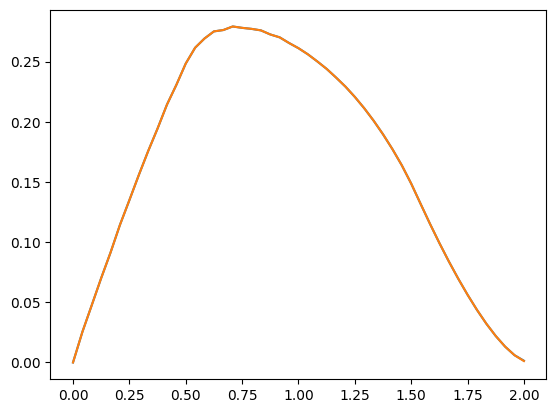

In [20]:
q_bins, I_bins = radially_average_ctf(asymmetric_detector_ctf)
q_bins_2, I_bins_2 = radially_average_ctf(ssb_ctf_gamma)
plt.plot(q_bins,I_bins)
plt.plot(q_bins_2,I_bins_2)

In [22]:
normalized_aperture = probe_array_fourier_0 / np.sqrt(np.sum(probe_array_fourier_0**2))

In [62]:
detector_com_y

[-0.01246803, 0.7257033, 0.012468031, -0.7257033]

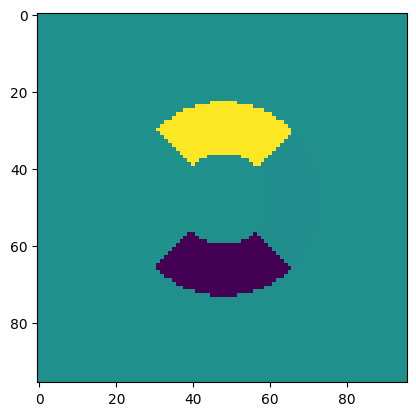

In [64]:
plt.imshow(
    np.fft.fftshift(
        np.tensordot(
            np.fft.ifftshift(virtual_masks_annular_4),
            np.array(detector_com_x),
            axes=(0,0)
        )
    )
)

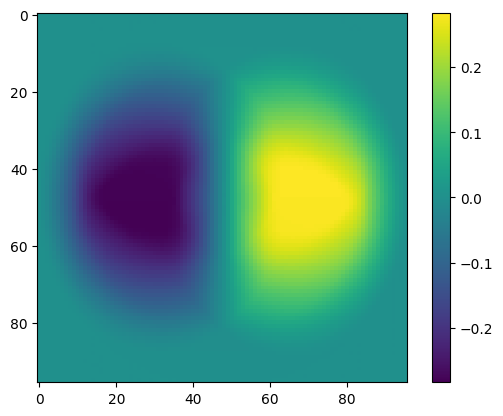

In [68]:
plt.imshow(
    np.fft.fftshift(ctf_y)
)
plt.colorbar()

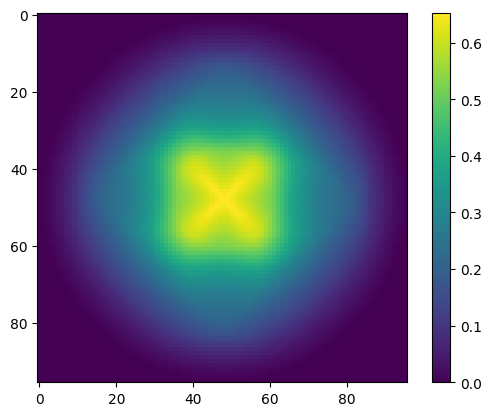

In [75]:
plt.imshow(
    np.fft.fftshift(
        ctf_annular_4
    )
)
plt.colorbar()

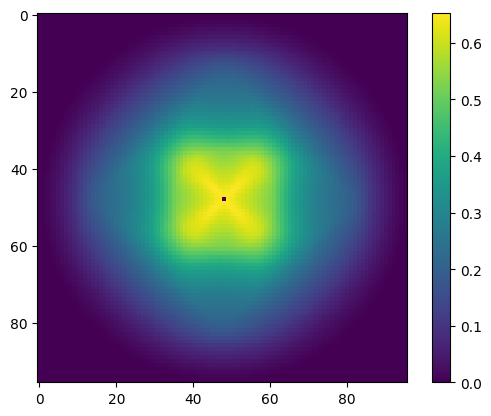

In [73]:
plt.imshow(
    np.fft.fftshift(
        ctf
    )
)
plt.colorbar()

In [37]:
ctf_x = (
    np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0]-virtual_masks_annular_4[2])
            ).conj() * np.fft.fft2(
                normalized_aperture
            )
        )
    )- np.real(
        np.fft.ifft2(
            np.fft.fft2(
                normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0]-virtual_masks_annular_4[2])
            ) * np.fft.fft2(
                normalized_aperture
            ).conj()
        )
    )
)

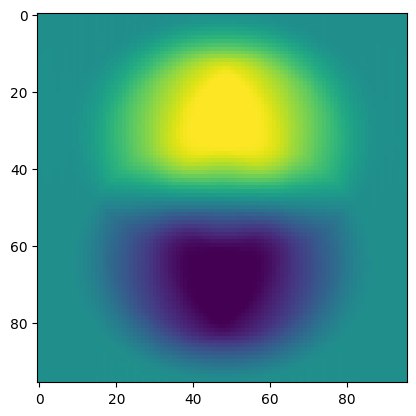

In [23]:
plt.imshow(
    np.fft.fftshift(
        np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0]-virtual_masks_annular_4[2])
                ).conj() * np.fft.fft2(
                    normalized_aperture
                )
            )
        )- np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0]-virtual_masks_annular_4[2])
                ) * np.fft.fft2(
                    normalized_aperture
                ).conj()
            )
        )
    )
)

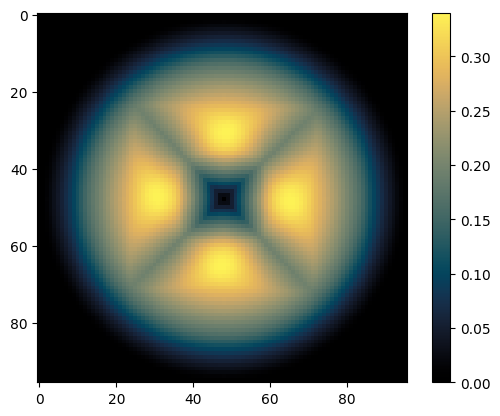

In [154]:
plt.imshow(
    np.fft.fftshift(
        sum(
            [
                np.abs(
                    np.real(
                        np.fft.ifft2(
                            np.fft.fft2(
                                normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[i])
                            ).conj() * np.fft.fft2(
                                normalized_aperture
                            )
                        )
                    )- np.real(
                        np.fft.ifft2(
                            np.fft.fft2(
                                normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[i])
                            ) * np.fft.fft2(
                                normalized_aperture
                            ).conj()
                        )
                    )
                )
                for i in range(4)
            ]
        )
    )/2,
    cmap=cmr.eclipse
)
plt.colorbar()

In [155]:
kxa

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04166667,  0.04166667,  0.04166667, ...,  0.04166667,
         0.04166667,  0.04166667],
       [ 0.08333334,  0.08333334,  0.08333334, ...,  0.08333334,
         0.08333334,  0.08333334],
       ...,
       [-0.125     , -0.125     , -0.125     , ..., -0.125     ,
        -0.125     , -0.125     ],
       [-0.08333334, -0.08333334, -0.08333334, ..., -0.08333334,
        -0.08333334, -0.08333334],
       [-0.04166667, -0.04166667, -0.04166667, ..., -0.04166667,
        -0.04166667, -0.04166667]], dtype=float32)

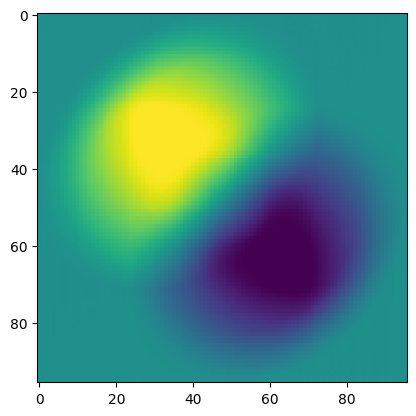

In [138]:
plt.imshow(
    np.fft.fftshift(
        np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0])
                ).conj() * np.fft.fft2(
                    normalized_aperture
                )
            )
        )- np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0])
                ) * np.fft.fft2(
                    normalized_aperture
                ).conj()
            )
        )
    )
)

In [142]:
    np.fft.fftshift(
        compute_weighted_ctf(
            np.fft.ifftshift(virtual_masks_annular_4[0])
        )
    )

0.0

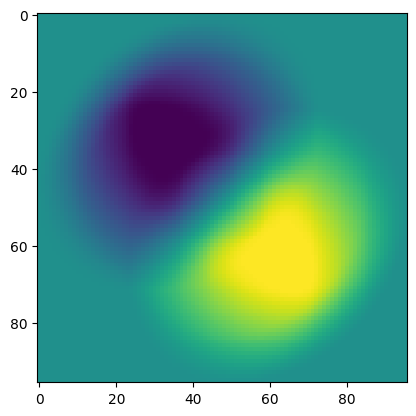

In [144]:
plt.imshow(
    np.fft.fftshift(
        compute_weighted_ctf(
            virtual_masks_annular_4[0]
        )
    )
)

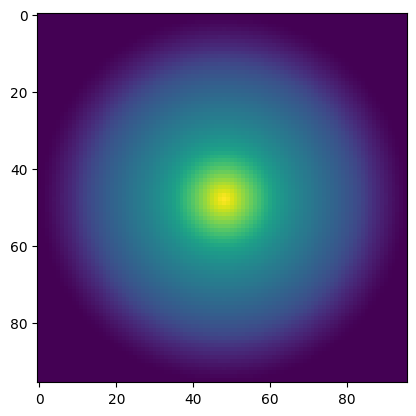

In [132]:
plt.imshow(
    np.fft.fftshift(
        np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0])
                ).conj() * np.fft.fft2(
                    normalized_aperture
                )
            )
        ) +         np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[1])
                ).conj() * np.fft.fft2(
                    normalized_aperture
                )
            )
        ) +         np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[2])
                ).conj() * np.fft.fft2(
                    normalized_aperture
                )
            )
        ) +         np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[3])
                ).conj() * np.fft.fft2(
                    normalized_aperture
                )
            )
        )
    )
)

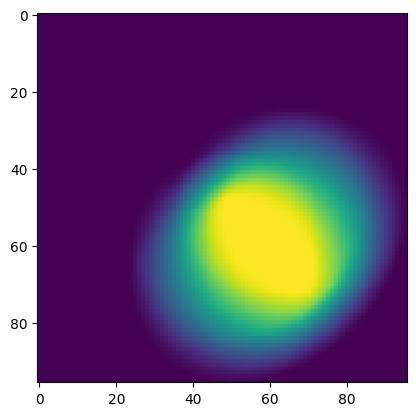

In [127]:
plt.imshow(
    np.fft.fftshift(
        np.real(
            np.fft.ifft2(
                np.fft.fft2(
                    normalized_aperture * np.fft.ifftshift(virtual_masks_annular_4[0])
                ) * np.fft.fft2(
                    normalized_aperture
                ).conj()
            )
        )
    )
)

In [ ]:
np.real(
    np.fft.ifft2(
        np.abs(
            np.fft.fft2(
                normalized_aperture
            )
        )**2
    )
)

In [12]:
def autocorrelation(array):
    """ """
    return np.real(
        np.fft.ifft2(
            np.abs(
                np.fft.fft2(
                    array
                )
            )**2
        )
    )

def autocorrelation_segmented(
    array,
    center_centered_masks,
):
    """ """
    corner_centered_intensities_sum = corner_centered_intensities.sum((-1,-2))
    masks = np.fft.ifftshift(np.asarray(center_centered_masks),axes=(-1,-2))

    return np.real(
        np.fft.ifft2(
            np.abs(
                np.fft.fft2(
                    array
                )
            )**2
        )
    )

In [30]:
# summed_mask = np.fft.ifftshift(sum(virtual_masks_annular_4))
# summed_mask = np.fft.ifftshift(virtual_masks_annular_4[0])
autocorrelation_annular_4_a = autocorrelation(
        np.fft.ifftshift(sum(virtual_masks_annular_4))
)

In [31]:
autocorrelation_annular_4_b = sum(
    [
        autocorrelation(
            np.fft.ifftshift(mask)
    )
        for mask in virtual_masks_annular_4
    ]
)

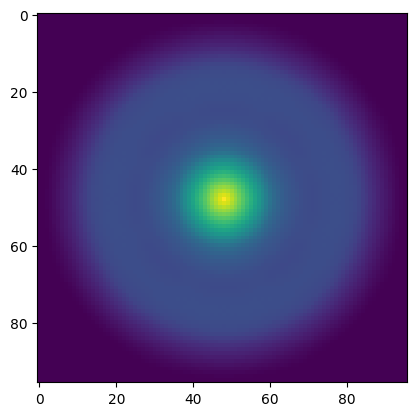

In [32]:
plt.imshow(
    np.fft.fftshift(
        autocorrelation_annular_4_a
    )
)

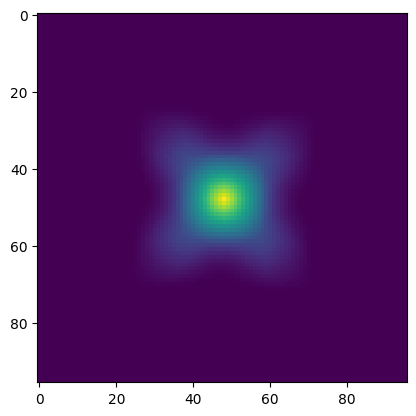

In [33]:
plt.imshow(
    np.fft.fftshift(
        autocorrelation_annular_4_b
    )
)

In [125]:
num_draws = 96
num_electrons_per_probe = 1e6

In [126]:
finite_icoms_annular_4 = np.empty((num_draws,n,n),dtype=np.float32)

for i in tqdm.trange(num_draws):
    
    finite_icoms_annular_4[i] = compute_finite_icom_segmented(
        ints,
        num_electrons_per_probe,
        virtual_masks_annular_4
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████| 96/96 [04:08<00:00,  2.59s/it]


In [10]:


finite_icoms = np.empty((num_draws,n,n),dtype=np.float32)

for i in tqdm.trange(num_draws):
    
    finite_icoms[i] = compute_finite_icom(
        ints,
        num_electrons_per_probe
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████| 96/96 [04:43<00:00,  2.95s/it]


In [14]:
def spectral_snr(ctf_arrays, radial_average=False):
    """ """ 
    abs_mean = np.abs(ctf_arrays.mean(0))
    std_ddof_1 = ctf_arrays.std(0,ddof=1)
    if radial_average:
        _, abs_mean = radially_average_ctf(abs_mean)
        _, std_ddof_1 = radially_average_ctf(std_ddof_1)
        
    return abs_mean/std_ddof_1

def radially_average_ctf(
    corner_centered_ctf,
    sampling=(sampling,sampling)
):
    """ returns the radially-averaged CTF of a corner-centered 2D CTF array. """
    nx, ny = corner_centered_ctf.shape
    sx, sy = sampling
    
    kx = np.fft.fftfreq(nx,sx)
    ky = np.fft.fftfreq(ny,sy)
    k  = np.sqrt(kx[:,None]**2 + ky[None,:]**2).ravel()

    intensity = corner_centered_ctf.ravel()

    bin_size = kx[1]-kx[0]
    k_bins = np.arange(0, k.max() + bin_size, bin_size)

    inds = k / bin_size
    inds_f = np.floor(inds).astype("int")
    d_ind = inds - inds_f

    nf = np.bincount(inds_f, weights=(1 - d_ind), minlength=k_bins.shape[0])
    nc = np.bincount(inds_f + 1, weights=(d_ind), minlength=k_bins.shape[0])
    n = nf + nc

    I_bins0 = np.bincount(
        inds_f, weights=intensity * (1 - d_ind), minlength=k_bins.shape[0]
    )
    I_bins1 = np.bincount(
        inds_f + 1, weights=intensity * (d_ind), minlength=k_bins.shape[0]
    )

    I_bins = (I_bins0 + I_bins1) / n

    inds = k_bins <= np.abs(kx).max()

    return k_bins[inds], I_bins[inds]

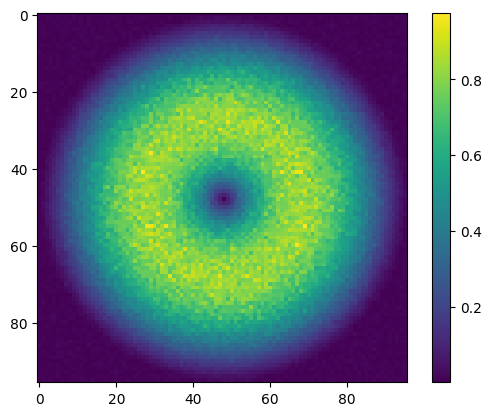

In [66]:
ssnr = spectral_snr(
    np.fft.fft2(finite_icoms),
) / np.sqrt(num_electrons_per_probe) * n

plt.imshow(
    np.fft.fftshift(
        ssnr
    ),
)
plt.colorbar()

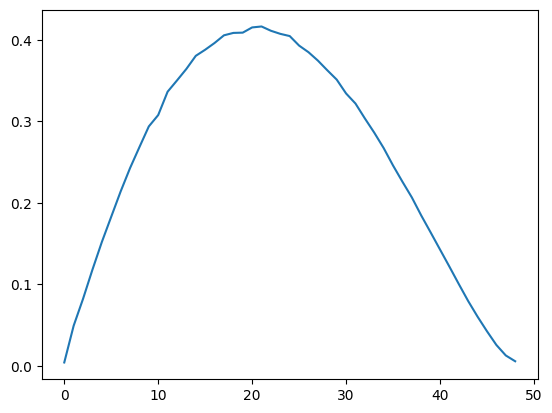

In [68]:
ssnr_radial_avg = spectral_snr(
    np.fft.fft2(finite_icoms),
    radial_average=True
) / np.sqrt(num_electrons_per_probe) * n / 2

plt.plot(ssnr_radial_avg)

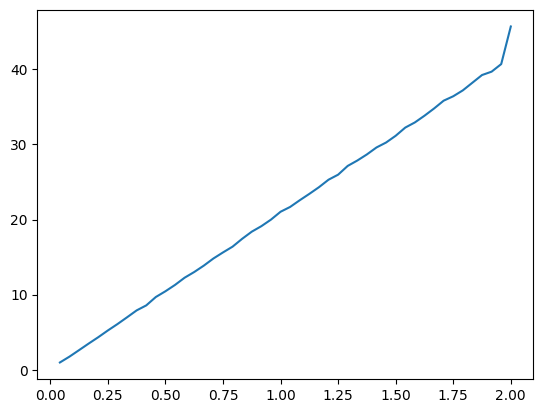

In [69]:
q_bins, I_bins = radially_average_ctf(
    np.fft.fft2(finite_icoms).std(0,ddof=1)
)

plt.plot(q_bins[1:],1/I_bins[1:])

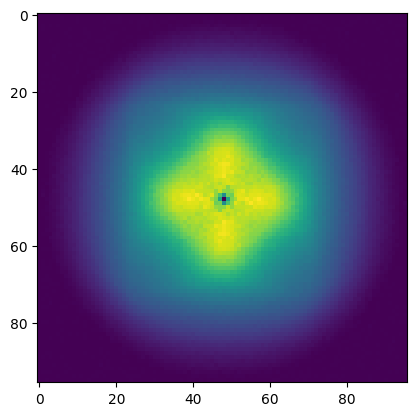

In [129]:
plt.imshow(
    np.fft.fftshift(np.abs(np.fft.fft2(finite_icoms_annular_4).mean(0)))
)

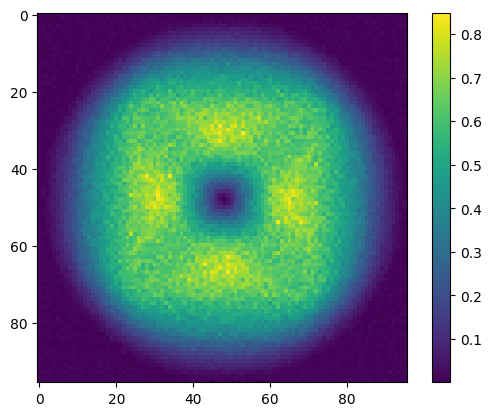

In [130]:
ssnr = spectral_snr(
    np.fft.fft2(finite_icoms_annular_4),
) / np.sqrt(num_electrons_per_probe) * n

plt.imshow(np.fft.fftshift(ssnr))
plt.colorbar()

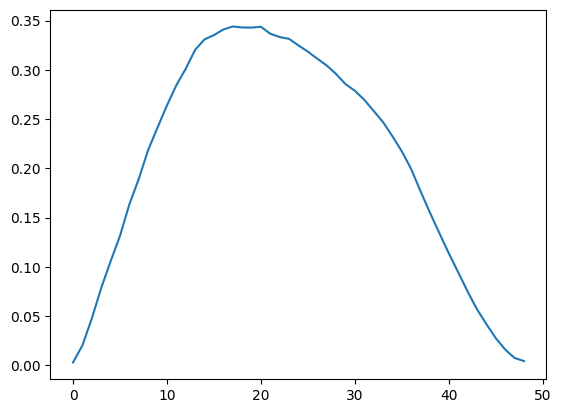

In [131]:
ssnr_radial_avg = spectral_snr(
    np.fft.fft2(finite_icoms_annular_4),
    radial_average=True
) / np.sqrt(num_electrons_per_probe) * n / 2

plt.plot(ssnr_radial_avg)

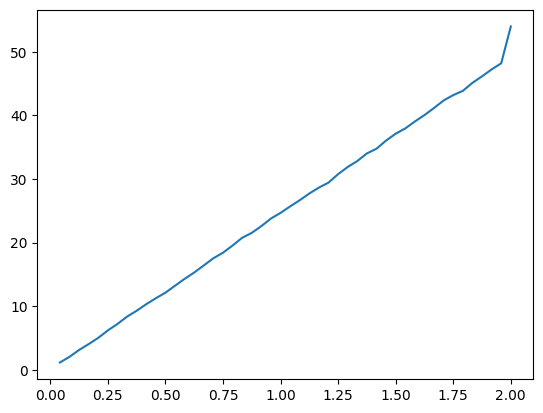

In [132]:
q_bins, I_bins = radially_average_ctf(
    np.fft.fft2(finite_icoms_annular_4).std(0,ddof=1)
)

plt.plot(q_bins[1:],1/I_bins[1:])